In [1]:
import pandas as pd
import random
import numpy as np
import time
import math
import sys
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import datatable as dt

from xgboost import plot_tree
from os import walk
from os import listdir
from os.path import isfile, join
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats import skew
from scipy.special import expit as sigmoid
from scipy.cluster.hierarchy import fclusterdata
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
DATA_PATH = ''
#HISTORY_PATH = "Voter_History_{0}"
PREPROCESSED_PATH = "preprocessed/{0}/florida_processed_{0}.csv"
COUPLES_PATH="couples/{0}/couples_{0}.csv"

In [6]:
preprocessed_date = '20160307'

In [7]:
couples_date = '20140319'

In [8]:
global_df = pd.read_csv(PREPROCESSED_PATH.format(preprocessed_date) , sep='\t')

/home/rahullachh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# global_df.isnull().sum()

In [10]:
global_df.head()

,county_code,voter_id,last_name,first_name,requested_public_records_exemption,residence_addr_line_1,residence_addr_line_2,residence_city,residence_zipcode,gender,race,birth_date,registration_date,party_affiliation,precinct,voter_status,age,residence_zipcode_5,residence_zipcode_4,uniq_addr
0,ALA,100003724,dungan,christine,N,6323 nw 37th ter,NaN,gainesville,32653,F,5,03/01/1945,03/16/1973,DEM,45,ACT,71,32653,NaN,6323 nw 37th ter gainesville 32653
1,ALA,100003725,dungan,richard,N,6326 nw 37th ter,NaN,gainesville,32653,M,5,09/09/1932,10/04/1960,DEM,45,ACT,83,32653,NaN,6326 nw 37th ter gainesville 32653
2,ALA,100005820,haskins,terry,N,7948 nw 49th way,NaN,gainesville,32653,M,5,06/19/1946,06/25/1968,DEM,45,ACT,69,32653,NaN,7948 nw 49th way gainesville 32653
3,ALA,100009183,matthews,janet,N,2712 sw 5th pl,NaN,gainesville,32607,F,5,09/28/1939,08/07/1970,DEM,26,ACT,76,32607,NaN,2712 sw 5th pl gainesville 32607
4,ALA,100010140,niederlitz,mary,N,1732 nw 7th ave,NaN,gainesville,32603,F,5,03/01/1923,02/09/1972,DEM,5,INA,93,32603,NaN,1732 nw 7th ave gainesville 32603


In [11]:
req_cols = ['last_name', 'race', 'first_name']
global_df = global_df.dropna(subset=req_cols)

In [12]:
global_df.isnull().sum()

county_code                                  0
voter_id                                     0
last_name                                    0
first_name                                   0
requested_public_records_exemption           0
residence_addr_line_1                        0
residence_addr_line_2                 10795885
residence_city                               0
residence_zipcode                            0
gender                                       0
race                                         0
birth_date                                   0
registration_date                            0
party_affiliation                            0
precinct                                     0
voter_status                                 0
age                                          0
residence_zipcode_5                          0
residence_zipcode_4                   11208251
uniq_addr                                    0
dtype: int64

In [13]:
global_df.shape

(13254464, 20)

In [14]:
couples_df = pd.read_csv(COUPLES_PATH.format(couples_date) , sep='\t')

/home/rahullachh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
couples_df[["uniq_addr"]].head()

,uniq_addr
0,1 clay county grn cv spgs 32043
1,4923 adra ct fleming island 32003
2,2332 birdwood dr orange park 32073
3,3016 alpaca ave middleburg 32068
4,6653 immokalee rd keystone heights 32656


## Collecting Addresses of voters

In [17]:
addr_df=global_df[['uniq_addr','voter_id']] 

In [19]:
couples_df_found = pd.merge(couples_df, addr_df, left_on=["voter_id_L"], right_on=["voter_id"], suffixes=["","_L"])

### Removing extra column generated of voter id

In [22]:
del couples_df_found['voter_id']

In [23]:
couples_df_found = pd.merge(couples_df_found, addr_df, left_on=["voter_id_R"], right_on=["voter_id"], suffixes=["","_R"])

### Removing extra column generated of voter id

In [28]:
del couples_df_found['voter_id']

In [29]:
couples_df_found[["voter_id_L","voter_id_R", "uniq_addr_L","uniq_addr_R"]].head()

,voter_id_L,voter_id_R,uniq_addr_L,uniq_addr_R
0,111224731,114194885,1 clay county grn cv spgs 32043,1 clay county grn cv spgs 32043
1,102846326,102848834,4923 adra ct fleming island 32003,4923 adra ct fleming island 32003
2,102846332,102848464,2332 birdwood dr orange park 32073,2332 birdwood dr orange park 32073
3,102846804,102933269,3016 alpaca ave middleburg 32068,3016 alpaca ave middleburg 32068
4,102840283,102841076,6653 immokalee rd keystone heights 32656,6653 immokalee rd keystone heights 32656


In [30]:
couples_df_found['separated'] = couples_df_found.apply(lambda x : x.uniq_addr_L != x.uniq_addr_R, axis=1)

## Separation percentage

In [108]:
couples_df_found['separated'].value_counts()

False    2408184
True      277206
Name: separated, dtype: int64

In [31]:
couples_df_found['separated'].value_counts()/couples_df_found['separated'].shape

False    0.896773
True     0.103227
Name: separated, dtype: float64

In [109]:
# couples_df_found.isnull().sum()

In [110]:
couples_df_found.head()

,county_code_L,voter_id_L,last_name_L,first_name_L,residence_addr_line_1_L,residence_addr_line_2_L,residence_city_L,residence_zipcode_L,gender_L,race_L,...,party_affiliation_R,precinct_R,voter_status_R,age_R,residence_zipcode_5_R,residence_zipcode_4_R,age_diff,uniq_addr_L,uniq_addr_R,separated
0,CLA,111224731,clegg,bonnie,1 clay county,NaN,grn cv spgs,32043,F,5.0,...,REP,606,ACT,62,32043,NaN,0,1 clay county grn cv spgs 32043,1 clay county grn cv spgs 32043,False
1,CLA,102846326,champion,elizabeth,4923 adra ct,NaN,fleming island,320037873,F,5.0,...,REP,414,ACT,57,32003,7873.0,0,4923 adra ct fleming island 32003,4923 adra ct fleming island 32003,False
2,CLA,102846332,rund,matthew,2332 birdwood dr,NaN,orange park,320735324,M,5.0,...,REP,210,ACT,80,32073,5324.0,0,2332 birdwood dr orange park 32073,2332 birdwood dr orange park 32073,False
3,CLA,102846804,de gidio,valrae,3016 alpaca ave,NaN,middleburg,320686413,F,5.0,...,REP,508,ACT,71,32068,6413.0,0,3016 alpaca ave middleburg 32068,3016 alpaca ave middleburg 32068,False
4,CLA,102840283,pike,anna,6653 immokalee rd,NaN,keystone heights,326568990,F,5.0,...,REP,702,ACT,73,32656,8990.0,0,6653 immokalee rd keystone heights 32656,6653 immokalee rd keystone heights 32656,False


## Convert race categorical 

In [126]:
race_codes = {
    1: "American Indian/Alaskan Native",
    2: "Asian/Pacific Islander",
    3: "Black/Not Hispanic",
    4: "Hispanic",
    5: "White",
    6: "Other",
    7: "Mutli-racial",
    9: "Unknown"
}

## Converting race codes to corresponding race-descriptions

In [208]:
def race_code_lambda(row, subscript):
    if pd.isnull(row["race_" + subscript]):
        return None
    code = int(row["race_" + subscript])
    return race_codes[code]

In [209]:
couples_df_found["race_desc_L"] = couples_df_found.apply(lambda x: race_code_lambda(x, "L"), axis=1)
couples_df_found["race_desc_R"] = couples_df_found.apply(lambda x: race_code_lambda(x, "R"), axis=1)

## Feature wise separation percentage

In [132]:
cols = ["party_affiliation", "gender", "race_desc"]
unique_dic = {}
for c in cols:
    unique_dic[c] = set(global_df[c].unique())

## Demographic Percentages

In [140]:
party_affiliation_counts = {}
race_counts = {}

party_affiliation_percentages = {}
race_percentages = {}

total = global_df.shape[0]
for cat_value in unique_dic["party_affiliation"]:
    party_affiliation_counts[cat_value] = global_df[global_df["party_affiliation"] == cat_value].shape[0]
    party_affiliation_percentages[cat_value] = 100.0 * global_df[global_df["party_affiliation"] == cat_value].shape[0]/total

for cat_value in unique_dic["race_desc"]:
    race_counts[str(cat_value)] = global_df[global_df["race_desc"] == cat_value].shape[0]
    race_percentages[str(cat_value)] =  100.0 * global_df[global_df["race_desc"] == cat_value].shape[0]/total

In [147]:
race_percentages

{'Black/Not Hispanic': 13.572717840570544,
 'White': 65.08963319829455,
 'American Indian/Alaskan Native': 0.322419676872637,
 'Mutli-racial': 0.5590871120854076,
 'Unknown': 2.07270546738065,
 'Hispanic': 15.109551016170855,
 'Asian/Pacific Islander': 1.772685790990869,
 'Other': 1.5011998976344876}

## Thresholding Demographics
For Race we stick to 5% </br>
For Party affiliation we stick to 5%

In [148]:
race_percent_threshold = 5.0
race_other_groups = []
for cat_value in race_percentages:
    if race_percentages[cat_value] <= race_percent_threshold:
        race_other_groups.append(cat_value)

In [150]:
party_percent_threshold = 5.0
party_other_groups = []
for cat_value in party_affiliation_percentages:
    if party_affiliation_percentages[cat_value] <= party_percent_threshold:
        party_other_groups.append(cat_value)

In [155]:
race_other_groups

['American Indian/Alaskan Native',
 'Mutli-racial',
 'Unknown',
 'Asian/Pacific Islander',
 'Other']

In [156]:
global_df.shape

(13254464, 21)

In [157]:
print(str(unique_dic))

{'party_affiliation': {'NPA', 'DEM', 'ECO', 'CPF', 'AIP', 'PSL', 'IDP', 'GRE', 'INT', 'LPF', 'REF', 'REP'}, 'gender': {'U', 'F', 'M'}, 'race_desc': {'Black/Not Hispanic', 'White', 'American Indian/Alaskan Native', 'Mutli-racial', 'Unknown', 'Hispanic', 'Asian/Pacific Islander', 'Other'}}


## Generate Pair-wise stats by feature
Current focus is only on gender/race/political-affiliation

In [168]:
import time

def generate_pair_stats_by_feature(global_df, couples_df_found, feature, stats={}):
    print("Collecting uniques by feature: " + feature)
    unique_vals = list(global_df[feature].unique())
    cat_combinations = list(combinations(list(unique_vals), 2))
    
    stats[feature] = {}
    print("Processing : " + feature + " : Total comb: " + str(len(cat_combinations)))
    i = 0
    start_time = time.time()
    for comb in cat_combinations:
        first_val = comb[0]
        second_val = comb[1]
        
        left_right = couples_df_found[(couples_df_found[feature + "_L"] == first_val) & (couples_df_found[feature + "_R"] == second_val)]
        right_left = couples_df_found[(couples_df_found[feature + "_L"] == second_val) & (couples_df_found[feature + "_R"] == first_val)]
        
        count = left_right[left_right["separated"] == True].shape[0]
        count += right_left[right_left["separated"] == True].shape[0]
        
        stat = {}
        stat["count"] = count
        
        if count == 0:
            continue
        
        stat["total"] = left_right.shape[0] + right_left.shape[0]
        stat["percent"] = count * 100.0/(left_right.shape[0] + right_left.shape[0])
        
        stats[feature][str(first_val) + "_" + str(second_val)] = stat
        
        i += 1
        
    print("Total value combinations process: " + str(i) + " Total time (secs): " + str(time.time() - start_time))
    
    print("Processing symmetric combinations: " + feature + " : Total comb: " + str(len(unique_vals)))
    for val in unique_vals:
        subset = couples_df_found[(couples_df_found[feature + "_L"] == val) & (couples_df_found[feature + "_R"] == val)]
        count = subset[subset["separated"] == True].shape[0]
        
        stat["count"] = count
        
        if count == 0:
            continue
        
        stat["total"] = subset.shape[0]
        stat["percent"] = count * 100.0/(subset.shape[0])
        
        stats[feature][str(val) + "_" + str(val)] = stat

    print("Done with processing feature: " + feature)
    
    return stats

In [169]:
# generate_pair_stats_by_feature(global_df, "party_affiliation")

In [178]:
def plot_pairwise_stat_by_feature(feature, stats):
    feature_stats = stats[feature]
    
    figures, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    
    percent_stats = []
    pair_combinations = []
    
    for pair_comb in feature_stats:
        percent_stats.append(feature_stats[pair_comb]["percent"])
        pair_combinations.append(pair_comb)

    plot_df = pd.DataFrame({"percent": percent_stats, "category_combination": pair_combinations})
    
    sns.barplot(x="percent", y="category_combination", data=plot_df, ax=axes)
    axes.set_title(feature)

    plt.tight_layout()

In [172]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "party_affiliation")

Processing : party_affiliation : Total comb: 66
Total value combinations process: 39 Total time (secs): 43.397648334503174
Processing symmetric combinations: party_affiliation : Total comb: 12
Done with processing feature: party_affiliation


In [175]:
stats

{'party_affiliation': {'DEM_REP': {'count': 38081,
   'total': 291666,
   'percent': 13.056372700280457},
  'DEM_IDP': {'count': 986, 'total': 6004, 'percent': 16.42238507661559},
  'DEM_NPA': {'count': 47232, 'total': 278974, 'percent': 16.930610021005542},
  'DEM_INT': {'count': 4108, 'total': 29047, 'percent': 14.142596481564361},
  'DEM_GRE': {'count': 178, 'total': 804, 'percent': 22.139303482587064},
  'DEM_REF': {'count': 24, 'total': 199, 'percent': 12.06030150753769},
  'DEM_LPF': {'count': 417, 'total': 2087, 'percent': 19.980833732630572},
  'DEM_ECO': {'count': 8, 'total': 18, 'percent': 44.44444444444444},
  'DEM_AIP': {'count': 9, 'total': 48, 'percent': 18.75},
  'DEM_CPF': {'count': 17, 'total': 93, 'percent': 18.27956989247312},
  'DEM_PSL': {'count': 2, 'total': 10, 'percent': 20.0},
  'REP_IDP': {'count': 802, 'total': 5911, 'percent': 13.567924209101674},
  'REP_NPA': {'count': 33912, 'total': 246367, 'percent': 13.76483051707412},
  'REP_INT': {'count': 3631, 'tota

In [214]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "gender", stats)

Processing : gender : Total comb: 3
Total value combinations process: 3 Total time (secs): 4.53747820854187
Processing symmetric combinations: gender : Total comb: 3
Done with processing feature: gender


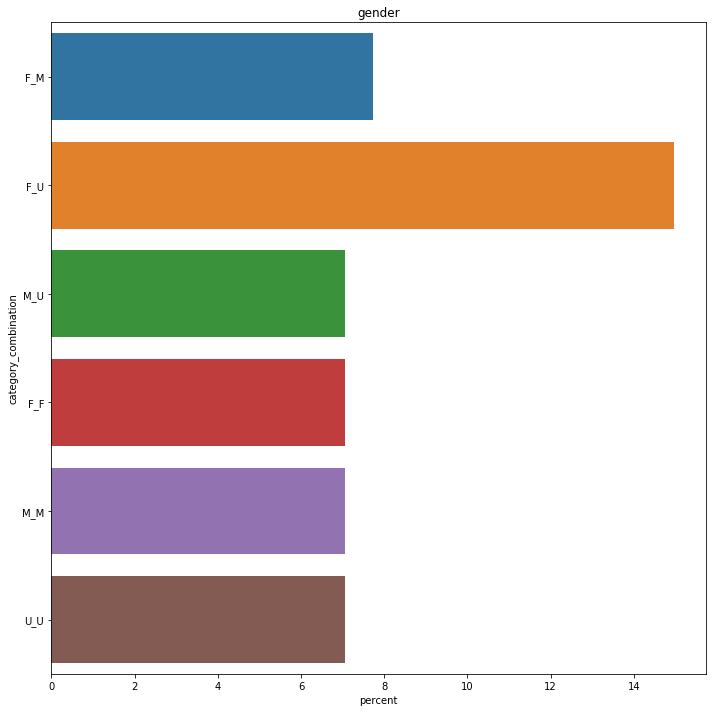

In [216]:
plot_pairwise_stat_by_feature("gender", stats)

In [37]:
from itertools import combinations
total_separated = couples_df_found[couples_df_found["separated"] == True].shape[0]
stats = {}
for c in cols:
    cat_combinations = list(combinations(list(unique_dic[c]), 2))
    stats[c] = {}
    print("Processing : " + c + " : Total comb: " + str(len(cat_combinations)))
    i = 0
    for comb in cat_combinations:
        first_val = comb[0]
        second_val = comb[1]
        
        left_right = couples_df_found[(couples_df_found[c + "_L"] == first_val) & (couples_df_found[c + "_R"] == second_val)]
        right_left = couples_df_found[(couples_df_found[c + "_L"] == second_val) & (couples_df_found[c + "_R"] == first_val)]
        count = left_right[left_right["separated"] == True].shape[0]
        count += right_left[right_left["separated"] == True].shape[0]
        stats[c][str(first_val) + "_" + str(second_val)] = count
        stats[c][str(first_val) + "_" + str(second_val) + "_" + "total"] = left_right.shape[0] + right_left.shape[0]
        i += 1
        
    print("Done with comb: " + str(i))
    
    print("Processing symmetric combinations: " + c + " : Total comb: " + str(len(unique_dic[c])))
    unique_vals = unique_dic[c]
    for val in unique_vals:
        subset = couples_df_found[(couples_df_found[c + "_L"] == val) & (couples_df_found[c + "_R"] == val)]
        count = subset[subset["separated"] == True].shape[0]
        stats[c][str(val) + "_" + str(val)] = count
        stats[c][str(val) + "_" + str(val) + "_" + "total"] = subset.shape[0]
    
    print("Done with processing column: " + c)

Processing : party_affiliation : Total comb: 66
Done with comb: 66
Processing symmetric combinations: party_affiliation : Total comb: 12
Done with processing column: party_affiliation
Processing : gender : Total comb: 3
Done with comb: 3
Processing symmetric combinations: gender : Total comb: 3
Done with processing column: gender
Processing : race : Total comb: 28
Done with comb: 28
Processing symmetric combinations: race : Total comb: 8
Done with processing column: race


In [54]:
race_codes = {
    1.0: "American Indian/Alaskan Native",
    2.0: "Asian/Pacific Islander",
    3.0: "Black/Not Hispanic",
    4.0: "Hispanic",
    5.0: "White",
    6.0: "Other",
    7.0: "Mutli-racial",
    9.0: "Unknown"
}

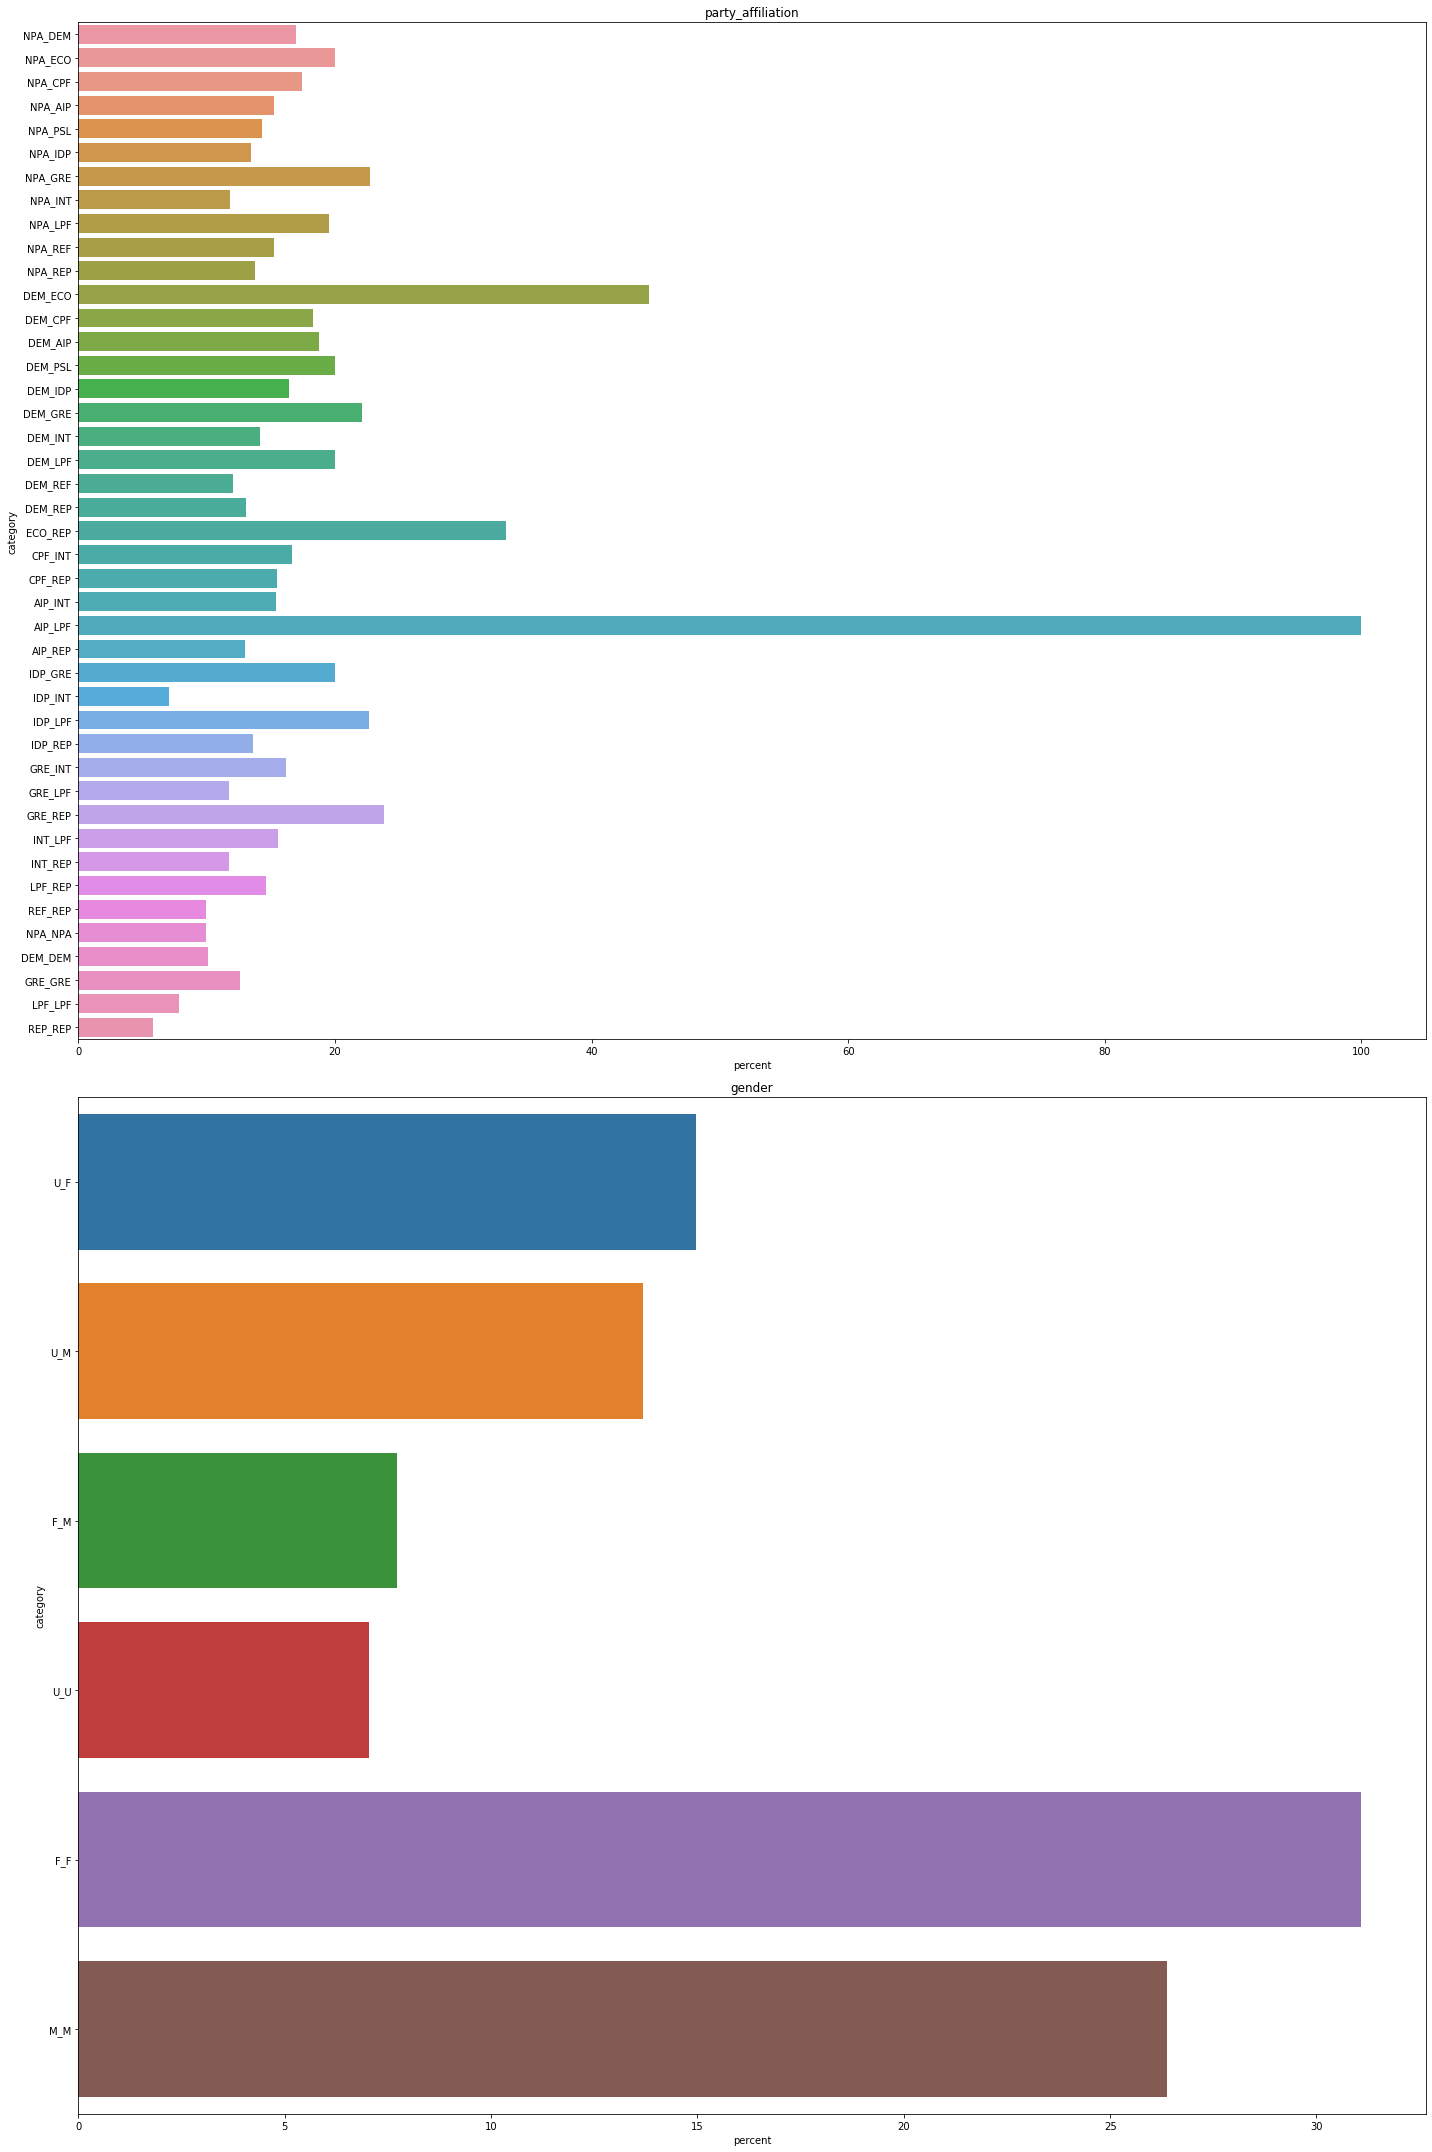

In [92]:
figures, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,30))
race_df = None
index = 0
for col in stats:
    col_stats = stats[col]
    percent_stats = {}
    for c in col_stats:
        if "total" in c:
            continue
        
        total = col_stats[c + "_" + "total"]
        if total == 0:
            continue
            
        p = col_stats[c] * 100.0/total
        if p < 5.0:
            continue
        percent_stats[c] = p
    
    plot_df = pd.DataFrame({"percent": list(percent_stats.values()), "category": list(percent_stats.keys()) })

    plot_df["percent_str"] = plot_df["percent"].apply(str)
    
#     sns.barplot(x="category", y="percent", data=plot_df, ax=axes[index])
    
#     sns.barplot(x="percent_str", y="category", data=plot_df, ax=axes[index])
    if col == "race":
        race_df = plot_df
#         sns.barplot(x="category", y="percent", data=plot_df, ax=axes[index])
    else:
        sns.barplot(x="percent", y="category", data=plot_df, ax=axes[index])
        axes[index].set_title(col)
        

    index += 1

plt.tight_layout()

In [93]:
race_df.shape

(35, 3)

In [95]:
def splitDataFrameIntoSmaller(df, chunkSize = 10000): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

In [96]:
splitDataFrameIntoSmaller(race_df, 5)

[     percent category         percent_str
 0   6.299213      1_2   6.299212598425197
 1  19.972640      1_3  19.972640218878247
 2  17.706013      1_4  17.706013363028955
 3  11.481141      1_5  11.481140754369825
 4  10.306407      1_6   10.30640668523677,
      percent category         percent_str
 5  22.641509      1_7  22.641509433962263
 6  13.712375      1_9    13.7123745819398
 7  19.082196      2_3  19.082195759512054
 8  18.245529      2_4  18.245529241179312
 9  11.757546      2_5  11.757546251217137,
       percent category         percent_str
 10   6.460980      2_6   6.460980036297641
 11  11.696429      2_7  11.696428571428571
 12   9.093971      2_9   9.093971034018187
 13  29.132424      3_4  29.132424355621964
 14  27.930085      3_5  27.930084745762713,
       percent category         percent_str
 15  14.555857      3_6  14.555857253685026
 16  25.028769      3_7  25.028768699654776
 17  16.845926      3_9  16.845926324280722
 18  16.340340      4_5   16.340340368359

In [89]:
race_df["percent_str"] = race_df["percent"].apply(str)
race_df["percent_round"] = race_df["percent"].round(2)

In [112]:
# sns.barplot(x="percent_round", y="category", data=race_df)